<a href="https://colab.research.google.com/github/Rishabh060105/indian-corporate-law/blob/main/Cognitivelab_assignment_notebook_Rishabh_Jain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CognitiveLab Research Internship Assignment

## Synthetic Data Generation and LLM Fine-tuning

### Overview
In this assignment for [CognitiveLab](https://cognitivelab.in/) Research Internship, you will:
1. Create a synthetic dataset for a use case of your choice
2. Fine-tune a small LLM using this dataset
3. Evaluate the model performance before and after fine-tuning

### What is Synthetic Data?
Synthetic data refers to artificially generated data rather than data collected from real-world events. In the context of this assignment:
- Data generated using AI/ML algorithms
- Data transformed from existing datasets (e.g., translations)
- Data created by prompting LLMs to generate samples

### Task Description
You're expected to:
1. Choose an interesting use case (suggestions below)
2. Generate a high-quality synthetic dataset
3. Fine-tune a small LLM (1-2B parameters)
4. Thoroughly evaluate the results
5. Document your approach and findings

### Potential Use Cases
- **Multilingual Translation**: Generate translation pairs for low-resource languages
- **Reasoning Tasks**: Create logical or mathematical reasoning problems
- **Vision-Language OCR**: Generate text extraction examples from images
- **Domain-Specific Q&A**: Create question-answer pairs for specialized domains
- **Code Generation**: Generate code examples for specific programming tasks

### Requirements
- The assignment must run on Google Colab with a single click
- Your synthetic dataset must be uploaded to Hugging Face Datasets
- Use small language models (eg Llama 3.2 1B and Qwen 3 0.6B / 1.7B) that can run on T4 GPUs
- Include comprehensive documentation of your approach

Good luck! We're looking for creative approaches to this problem - surprise us with your solution!

## 1. What is you Idea and use case you are trying to solve?
My idea is to create a specialized Question-Answering (Q&A) model focused on Indian Corporate Law.

The use case is to build a helpful assistant for law students, paralegals, or small business owners who need to quickly find answers to specific questions about regulations, compliance, and procedures under the Indian Companies Act, 2013. General-purpose LLMs often lack the deep, nuanced knowledge for such a specialized domain and may provide generic or incorrect information. By fine-tuning a model on a domain-specific synthetic dataset, I aim to create a more accurate and reliable tool


## 2. Environment Setup

In this section, we'll install all the necessary dependencies for our project. This includes libraries for:
- Data processing and manipulation
- LLM access and fine-tuning
- Evaluation metrics
- Hugging Face integration for dataset upload and model download

Run the cell below to set up your environment.

In [ ]:
# 1.1 Install all necessary dependencies and upgrade them
!pip install -q transformers datasets evaluate peft bitsandbytes accelerate
!pip install -q trl
!pip install -q huggingface_hub
!pip install -q groq
!pip install -q nltk rouge-score sacrebleu
!pip install -q bert_score  # Add BERTScore for better evaluation

# 1.2 Upgrade the key libraries to their latest versions
print("Upgrading TRL, PEFT, and Transformers...")
!pip install --upgrade -q trl peft transformers

# 1.3 Import libraries
import os
import json
import pandas as pd
from tqdm.auto import tqdm
import torch
from groq import Groq
from datasets import Dataset, DatasetDict
from google.colab import userdata
from huggingface_hub import login
import transformers
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer

# 1.4 Log in to Hugging Face
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Successfully logged into Hugging Face.")
except Exception as e:
    print("Please add your Hugging Face token to Colab Secrets with the name 'HF_TOKEN'.")

# 1.5 Check GPU availability and setup
!nvidia-smi
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
Upgrading TRL, PEFT, and Transformers...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 128.7 MB/s eta 0:00:00
Please add your Hugging Face token to Colab Secrets with the name 'HF_TOKEN'.
Fri Oct  3 03:36:51 2025       
+-----------------------------------------------------------------------------------------

In [ ]:
# import os

# print("🔄 Restarting the runtime to apply the library upgrades...")
# os.kill(os.getpid(), 9)

In [ ]:
# 2.1 Project Configuration
PROJECT_CONFIG = {
    "model_id": "microsoft/DialoGPT-small",  # Better for T4 GPU and dialogue-like QA
    "dataset_name": "indian-corporate-law-qa-enhanced",
    "hf_username": "ris322612",  # Update with your username
    "num_samples_to_generate": 750,  # Increased samples for better training
    "model_name": "llama-3.3-70b-versatile",
    "num_pairs_per_context": 4  # Generate more pairs per context
}

# 2.2 Securely load the Groq API Key
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    client = Groq(api_key=GROQ_API_KEY)
    print("Groq API client initialized successfully.")
except Exception as e:
    print("Please add your Groq API key to Colab Secrets with the name 'GROQ_API_KEY'.")
    print("You can get a free API key from: https://console.groq.com/keys")

Groq API client initialized successfully.


## 3. Synthetic Data Generation

In this section, we'll generate a synthetic dataset for our selected use case. The process involves:

1. Defining the data structure and schema
2. Setting up data generation techniques (LLM prompting, rules-based generation, etc.)
3. Creating the dataset
4. Validating data quality
5. Uploading to Hugging Face Datasets

Good examples of synthetic data generation include:
- Using LLMs to generate text samples based on specific prompts
- Using existing datasets to create variations (e.g., translations, paraphrasing)
- Using rules-based systems to generate structured data (e.g., JSON, CSV)
- Using data augmentation techniques to create variations of existing data
- Using generative models to create new data points based on existing distributions

ps: you can always start with a existing dataset and augment it with synthetically.

Some libraries you can use for data generation:
- https://github.com/meta-llama/synthetic-data-kit
- https://github.com/argilla-io/distilabel
- https://github.com/argilla-io/synthetic-data-generator

For llms you can use local llm , use free apis from [groq](https://groq.com/) anything else you can find.

Choose one of the example approaches below or create your own. Remember to document your methodology.

### the dataset generated must be uploaded to hugging face datasets
refrence : https://huggingface.co/docs/datasets/upload_dataset

In [ ]:
# First, let's add the model name to our config for better organization
PROJECT_CONFIG["model_name"] = "llama-3.3-70b-versatile"
PROJECT_CONFIG["num_pairs_per_context"] = 3 # Generate 3 Q&A pairs per text snippet

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 3.1 Define the BATCH data generation function
def generate_qa_batch(client, context):
    """Generates a BATCH of diverse question-answer pairs from a single context."""
    # <-- CHANGED: New prompt asks for multiple, diverse pairs in a JSON list
    system_prompt = (
        "You are a helpful assistant that generates multiple, diverse question-answer pairs based *strictly* on the provided legal text. "
        "The answer must be derived *only* from the context and be as concise as possible while still being informative. "
        "Create different types of questions (e.g., 'what is', 'how does', 'what are the requirements for'). "
        "Ensure the generated questions can be answered *directly* by the context provided. "
        "The output must be a single JSON object with a key 'qa_pairs' containing a list of objects, "
        "where each object has 'instruction', 'context', and 'response' keys."
    )
    user_prompt = (
        f"Generate {PROJECT_CONFIG['num_pairs_per_context']} diverse question-answer pairs based on the following text:\n\n{context}"
    )

    try:
        completion = client.chat.completions.create(
            model=PROJECT_CONFIG["model_name"],
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"}
        )
        # <-- CHANGED: We now expect a list of pairs within a root key
        response_json = json.loads(completion.choices[0].message.content)
        return response_json.get("qa_pairs", [])
    except Exception as e:
        print(f"Error generating QA batch for context '{context[:50]}...': {e}")
        return None

# 3.2 Prepare source material (no changes needed here)
legal_texts = [
    # ... (your list of legal texts remains the same) ...
    "Corporate Social Responsibility (CSR): Eligible companies (based on profit, turnover, or net worth) must spend 2% of their average profits on social causes, with mandatory CSR policy, impact reporting, and oversight.",
    "One Person Company (OPC): The Act allows a single individual to form a private company, helping small entrepreneurs and startups with simplified compliance.",
    "Independent Directors & Board Governance: Public companies must appoint independent directors and, in some cases, women directors, improving objectivity and corporate fairness.",
    "Auditor Rotation & Financial Disclosure: The Act ensures transparency by requiring auditor rotation (every 5–10 years as per rules) and comprehensive financial disclosures in financial statements.",
    "Streamlined Mergers & Procedures: Faster, simpler procedures for mergers, including cross-border mergers, and digital/e-governance facilities for filings, e-voting, and virtual meetings.",
    "Minority Shareholder Protection: The law protects minority interests through rights to challenge decisions and class action suits.",
    "Strict Penalties: Harsher punishments for violating legal provisions, including fines and possible imprisonment for directors and auditors, discouraging fraud and mismanagement.",
    "According to Section 149(1) of the Companies Act, 2013, a public company must have a minimum of three directors, a private company must have a minimum of two directors, and a One Person Company must have at least one director.",
    "Section 96 of the Companies Act, 2013 mandates that every company shall in each year hold in addition to any other meetings, a general meeting as its annual general meeting.",
    "As per Section 73 of the Companies Act, 2013, a company can accept deposits from its members and the public, subject to certain conditions and compliance requirements.",
    "Section 123 of the Companies Act, 2013 deals with the declaration of dividend. No dividend shall be declared or paid by a company for any financial year except out of the profits of the company for that year arrived at after providing for depreciation.",
    "Section 4 of the Companies Act, 2013 outlines the steps for the incorporation of a company, including the application for name availability, memorandum and articles of association, and registration with the Registrar of Companies.",
    "According to Section 135 of the Companies Act, 2013, every company having net worth of rupees five hundred crore or more, or turnover of rupees one thousand crore or more or a net profit of rupees five crore or more during the immediately preceding financial year shall constitute a Corporate Social Responsibility Committee of the Board.",
    "Section 53 of the Companies Act, 2013 prohibits a company from issuing shares at a discount, except in the case of issue of sweat equity shares or as otherwise provided in the Act.",
    "Section 62 of the Companies Act, 2013 deals with the further issue of share capital. Where a company having a share capital proposes to increase its subscribed capital by issue of further shares, such shares shall be offered to persons who, at the date of the offer, are holders of equity shares of the company, in proportion, as nearly as circumstances admit, to the paid-up share capital on those shares.",
    "Section 180 of the Companies Act, 2013 requires the approval of the shareholders by a special resolution for certain transactions, such as selling, leasing or otherwise disposing of the whole or substantially the whole of the undertaking of the company.",
    "Section 2(68) of the Companies Act, 2013 defines a private company as a company having a minimum paid-up share capital as may be prescribed, and which by its articles, restricts the right to transfer its shares, limits the number of its members to two hundred, and prohibits any invitation to the public to subscribe for any securities of the company.",
    "National Company Law Tribunal (NCLT): Handles disputes, insolvency cases, and winding up of companies, replacing the previous Company Law Board.",
    "Serious Fraud Investigation Office (SFIO): Investigates and prosecutes major corporate frauds, strengthening oversight and investor confidence.",
    "Types of Companies Classified: Public companies, private companies, One Person Company (OPC), Small company, dormant company, Nidhi company, Section 8 (non-profits), government, foreign, and listed/unlisted companies.",
    "Compliance and Governance: The law sets strict rules for disclosures, mandatory documentation in electronic form, board independence, and digital operations to encourage ethical conduct and improve ease of doing business",
    "Preliminary (Sections 1–2): Defines scope, applicability, and keywords of the Act, providing foundational regulatory concepts for all types of companies.",
    "Incorporation, Memorandum & Articles (Sections 3–22): Describes legal steps and required documents for forming a company, including Memorandum of Association and Articles of Association. Covers registration, commencement of business, and conversion between company types.",
    "Incorporation, Memorandum & Articles (Sections 3–22): Allows formation of “One Person Company” and “Section 8” (non-profit) organizations.",
    "Prospectus & Securities (Sections 23–42): Covers issuance and allotment of securities, public offers, shelf/red herring prospectus, criminal/civil liability for misstatements, and SEBI’s role. Mandates disclosures for public fundraising.",
    "Management and Administration (Sections 88–122): Annual General Meeting (AGM) procedures, voting rights, resolutions, registers of members, beneficial ownership, and dispute powers of NCLT.",
    "Corporate Governance (Various): Mandates independent directors, women directors (in certain cases), and resident directors for prescribed companies, strengthening oversight and board diversity.",
    "Corporate Governance (Various): Auditor rotation and enhanced financial disclosure requirements boost transparency.",
    "Corporate Social Responsibility (CSR) (Section 135): Companies above set profit/net worth/turnover thresholds must form a CSR committee and spend 2% of average net profits on socially beneficial activities. Detailed reporting and compliance required.",
    "Types of Companies (Sections 2, Various): Act recognizes public companies, private companies (now up to 200 members), One Person Company, small companies, dormant companies (inactive for 2 years), Nidhi companies, and Section 8 companies. Definitions are crucial for compliance obligations.",
    "Prevention of Oppression and Mismanagement (Sections 241–246): Allows minority shareholders and other affected parties to take legal action against unfair treatment, protecting investor interests.",
    "Mergers, Amalgamations & Arrangements (Sections 230–240): Streamlines procedures for mergers and cross-border amalgamations, including valuation requirements and the possibility of reverse mergers.",
    "Inspection, Inquiry & Investigation (Sections 206–229): Provides powers to regulators (SFIO, MCA, ROC) to inspect company records, investigate fraud, and ensure compliance, protecting stakeholders.",
    "Winding Up & Liquidation (Sections 270–365): Establishes procedures for dissolving companies, protection of creditors’ rights, and liquidation processes, overseen by the NCLT.",
    "Digital Governance and Transparency: E-filing, e-governance, virtual meetings, e-voting, and electronic document maintenance are mandatory, making compliance and research more efficient.",
    "Class Action Suits (Section 245): Enables shareholders and depositors to collectively sue companies, auditors, and experts for mismanagement or wrongful acts.",
    "Removal of Names, Revival & Sick Companies (Sections 248–269): Facilitates action on inactive companies, revives sick companies, and protects creditors’ rights."
]

# 3.3 Generate the dataset using the new batch method
synthetic_data = []
# <-- CHANGED: Simpler, more efficient loop. No need for repeats.
for context in tqdm(legal_texts, desc="Generating data from contexts"):
    if len(synthetic_data) >= PROJECT_CONFIG["num_samples_to_generate"]:
        break # Stop if we've already generated enough samples

    qa_batch = generate_qa_batch(client, context)
    if qa_batch and isinstance(qa_batch, list):
        synthetic_data.extend(qa_batch)

# Trim excess samples if we over-generated
if len(synthetic_data) > PROJECT_CONFIG["num_samples_to_generate"]:
    synthetic_data = synthetic_data[:PROJECT_CONFIG["num_samples_to_generate"]]


# 3.4 Convert to Dataset and split (no changes needed from here on)
if synthetic_data:
    df = pd.DataFrame(synthetic_data)
    # Final check to remove any rows that might be malformed
    df.dropna(subset=['instruction', 'context', 'response'], inplace=True)
    df = df[df['instruction'].apply(isinstance, args=(str,))]
    df = df[df['response'].apply(isinstance, args=(str,))]

    dataset = Dataset.from_pandas(df)

    # Split into training and testing sets
    train_test_split = dataset.train_test_split(test_size=0.1)

    # Upload to Hugging Face Datasets
    # Uncomment the line below to upload the dataset after successfully generating it
    try:
        # Use your Hugging Face username and the dataset name from PROJECT_CONFIG
        dataset.push_to_hub(f"{PROJECT_CONFIG['hf_username']}/{PROJECT_CONFIG['dataset_name']}")
        print(f"Dataset uploaded to Hugging Face: {PROJECT_CONFIG['hf_username']}/{PROJECT_CONFIG['dataset_name']}")
    except Exception as e:
        print(f"Error uploading dataset to Hugging Face: {e}")


    print(f"\nSuccessfully generated {len(synthetic_data)} high-diversity samples.")
    print("First 5 generated samples:")
    for i in range(min(5, len(synthetic_data))):
        print(synthetic_data[i])
    # print("\nDataset upload code is ready but commented out. Uncomment and replace 'YOUR_HF_USERNAME' when ready to upload.")

else:
    print("No synthetic data was generated.")

Generating data from contexts:   0%|          | 0/37 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 14.9kB / 14.9kB            

Dataset uploaded to Hugging Face: ris322612/indian-corporate-law-qa-enhanced

Successfully generated 111 high-diversity samples.
First 5 generated samples:
{'instruction': 'What is the percentage of average profits that eligible companies must spend on social causes for Corporate Social Responsibility?', 'context': 'Corporate Social Responsibility (CSR): Eligible companies (based on profit, turnover, or net worth) must spend 2% of their average profits on social causes, with mandatory CSR policy, impact reporting, and oversight.', 'response': '2%'}
{'instruction': 'What are the requirements for eligible companies regarding Corporate Social Responsibility policy and reporting?', 'context': 'Corporate Social Responsibility (CSR): Eligible companies (based on profit, turnover, or net worth) must spend 2% of their average profits on social causes, with mandatory CSR policy, impact reporting, and oversight.', 'response': 'Mandatory CSR policy, impact reporting, and oversight'}
{'instruction

In [ ]:
# Define the formatting function that will be applied to each example
def format_dataset_entry(example):
    # This function takes a single dictionary (one row of data)
    # and returns a dictionary with the new 'text' field.
    return {
        "text": f"### Instruction: {example['instruction']}\n### Context: {example['context']}\n### Response: {example['response']}"
    }

# Apply this function to both the training and testing sets
# Assuming 'train_test_split' dataset is available from the previous step
train_dataset_formatted = train_test_split["train"].map(format_dataset_entry)
# We don't need to format the test set for training, but it's good practice if you evaluate later
# test_dataset_formatted = train_test_split["test"].map(format_dataset_entry)

print("Dataset pre-formatted with a 'text' column.")
print("Example of a formatted entry:")
# Print the first formatted example
if len(train_dataset_formatted) > 0:
    print(train_dataset_formatted[0]['text'])
else:
    print("Training dataset is empty.")

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset pre-formatted with a 'text' column.
Example of a formatted entry:
### Instruction: How often does the Act require auditor rotation?
### Context: Auditor Rotation & Financial Disclosure: The Act ensures transparency by requiring auditor rotation (every 5–10 years as per rules) and comprehensive financial disclosures in financial statements.
### Response: every 5–10 years


In [ ]:
# Helper code to list all available models from Groq
try:
    models = client.models.list()
    print("Currently available Groq models:")
    for model in models.data:
        if model.active:
            print(f"- {model.id}")
except Exception as e:
    print(f"Could not fetch model list: {e}")

Currently available Groq models:
- meta-llama/llama-prompt-guard-2-86m
- llama-3.3-70b-versatile
- llama-3.1-8b-instant
- groq/compound-mini
- playai-tts-arabic
- openai/gpt-oss-20b
- meta-llama/llama-4-maverick-17b-128e-instruct
- playai-tts
- meta-llama/llama-guard-4-12b
- meta-llama/llama-4-scout-17b-16e-instruct
- gemma2-9b-it
- moonshotai/kimi-k2-instruct
- whisper-large-v3
- openai/gpt-oss-120b
- qwen/qwen3-32b
- moonshotai/kimi-k2-instruct-0905
- deepseek-r1-distill-llama-70b
- whisper-large-v3-turbo
- groq/compound
- allam-2-7b
- meta-llama/llama-prompt-guard-2-22m


## 4. Model Fine-tuning

Now that we have our synthetic dataset, let's fine-tune a small LLM using PEFT/LoRA techniques. This approach allows us to efficiently adapt the pre-trained model to our specific task without excessive computational requirements.

We'll:
1. Load the pre-trained model
2. Prepare the dataset in the correct format
3. Configure LoRA adapters
4. Fine-tune the model
5. Save the fine-tuned model

This section uses Parameter-Efficient Fine-Tuning (PEFT) with Low-Rank Adaptation (LoRA) to update only a small number of parameters, making it suitable for running on Colab's T4 GPU.

In [ ]:
# 4.6 Pre-format the training dataset
from datasets import Features, Value # Import Value

def pre_format_example(example):
    """Formats a single example into the desired prompt structure."""
    # Add checks for key existence
    instruction = example.get('instruction')
    context = example.get('context')
    response = example.get('response')

    if instruction is not None and context is not None and response is not None:
        return {"formatted_text": f"### Instruction: {instruction}\n### Context: {context}\n### Response: {response}"}
    else:
         # Optionally log a warning if a key is missing or value is None
         print(f"Warning: Skipping example due to missing or None value: {example}")
         return {"formatted_text": None} # Return None or an empty string for invalid examples

# Apply the pre-formatting function to the training dataset
# Use batched=False here as we are processing example by example
train_dataset_preformatted = train_test_split["train"].map(pre_format_example, batched=False)

# Remove examples where formatting failed (returned None)
train_dataset_preformatted = train_dataset_preformatted.filter(lambda x: x['formatted_text'] is not None)

# Explicitly define the features with the desired dtype for 'formatted_text'
original_features = train_dataset_preformatted.features.copy()
original_features['formatted_text'] = Value('string')
train_dataset_preformatted = train_dataset_preformatted.cast(original_features)


print("\nTraining dataset pre-formatted with 'formatted_text' column.")
print("Example of a pre-formatted entry:")
# Print the first pre-formatted example
if len(train_dataset_preformatted) > 0:
    print(train_dataset_preformatted[0]['formatted_text'])
else:
    print("Pre-formatted training dataset is empty.")

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/99 [00:00<?, ? examples/s]


Training dataset pre-formatted with 'formatted_text' column.
Example of a pre-formatted entry:
### Instruction: How often does the Act require auditor rotation?
### Context: Auditor Rotation & Financial Disclosure: The Act ensures transparency by requiring auditor rotation (every 5–10 years as per rules) and comprehensive financial disclosures in financial statements.
### Response: every 5–10 years


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import torch
from trl import SFTTrainer, SFTConfig

# 4.1 Load the base model with 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,  # Enable double quantization for better accuracy
)

# Update model_id to Qwen1.5-1.8B-Chat
PROJECT_CONFIG["model_id"] = "Qwen/Qwen1.5-1.8B-Chat"

model = AutoModelForCausalLM.from_pretrained(
    PROJECT_CONFIG["model_id"],
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=False,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,  # Ensure consistent dtype
)

model.config.pretraining_tp = 1

# 4.2 Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(PROJECT_CONFIG["model_id"], trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 4.3 Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# 4.4 Configure LoRA adapters with improved parameters, targeting Qwen modules
lora_config = LoraConfig(
    r=64,  # Increased rank for better capacity
    lora_alpha=128,  # Increased alpha for stronger adaptation
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], # These are the correct modules for Qwen1.5
    lora_dropout=0.05,  # Reduced dropout for better learning
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)


model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# 4.5 Define training arguments with optimized parameters
sft_config = SFTConfig(
    output_dir="./results",
    num_train_epochs=5,  # Increased epochs for better convergence
    per_device_train_batch_size=2,  # Reduced batch size to fit memory better
    gradient_accumulation_steps=4,  # Increased to maintain effective batch size
    optim="paged_adamw_8bit",
    save_steps=50,
    logging_steps=5,
    learning_rate=5e-5,  # Slightly higher learning rate
    weight_decay=0.01,  # Increased weight decay for regularization
    fp16=False,  # Disabled as requested
    bf16=True,
    max_grad_norm=1.0,  # Increased for stability
    max_steps=-1,
    warmup_ratio=0.1,  # Increased warmup
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="none",
    max_length=1024,  # Removed as it's not a valid argument for SFTConfig
    packing=False,
    dataset_text_field="formatted_text",
    eval_strategy="steps",  # Add evaluation
    eval_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Create evaluation dataset from test split
eval_dataset_formatted = train_test_split["test"].map(pre_format_example, batched=False)
eval_dataset_formatted = eval_dataset_formatted.filter(lambda x: x['formatted_text'] is not None)

# 4.6 Create the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset_preformatted,
    eval_dataset=eval_dataset_formatted,  # Add evaluation dataset
    peft_config=lora_config,
)

print("Starting training...")
# Enable training by default
trainer.train()

# 4.7 Save the fine-tuned model
print("Saving fine-tuned model...")
trainer.model.save_pretrained(sft_config.output_dir)
tokenizer.save_pretrained(sft_config.output_dir)
print(f"Fine-tuned model saved to {sft_config.output_dir}")

# Clear GPU memory
del model
del trainer
torch.cuda.empty_cache()
print("Training completed and GPU memory cleared.")

trainable params: 59,965,440 || all params: 1,896,794,112 || trainable%: 3.1614


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
25,1.441100,1.475229,1.482533,14036.000000,0.673771
50,0.660900,1.027043,1.013127,27991.000000,0.760382


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Saving fine-tuned model...
Fine-tuned model saved to ./results
Training completed and GPU memory cleared.


In [ ]:
!pip install -q trl

## 5. Model Evaluation

Now that we have fine-tuned our model, let's evaluate its performance by comparing it with the base model. We'll assess how well our synthetic data helped improve the model's abilities on our target task.

We'll:
1. Load both the base and fine-tuned models
2. Define appropriate evaluation metrics
3. Perform inference on test examples
4. Compare and analyze the results
5. Visualize performance differences

In [ ]:
!pip install -q evaluate

In [ ]:
# 5. Model Evaluation

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel # Import PeftModel for loading LoRA adapters
from datasets import Dataset # Import Dataset if needed for test data
from evaluate import load # Import evaluate for metrics

# Assume train_test_split is available from Section 3
# Prepare test data (you might want to pre-format this like the training data)
test_dataset = train_test_split["test"]

# Load the base model and tokenizer
# Use the same quantization config as training for consistency if evaluating on GPU
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    PROJECT_CONFIG["model_id"],
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_tokenizer = AutoTokenizer.from_pretrained(PROJECT_CONFIG["model_id"], trust_remote_code=True)
base_tokenizer.pad_token = base_tokenizer.eos_token
base_tokenizer.padding_side = "left" # Set padding side to left for generation

# Define a function for generating predictions
def generate_response(model, tokenizer, instruction, context, max_length=512):
    """Generates a response from the model given an instruction and context."""
    prompt = f"### Instruction: {instruction}\n### Context: {context}\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(model.device)

    # Generate response
    with torch.no_grad():
        output_sequences = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True, # Set to True for more varied responses, False for greedy
            top_k=50,
            top_p=0.95,
            temperature=0.7,
        )

    # Decode the generated sequence, skipping the prompt
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    # Extract only the response part (after "### Response:")
    response_prefix = "### Response:"
    if response_prefix in generated_text:
        response_start = generated_text.find(response_prefix) + len(response_prefix)
        extracted_response = generated_text[response_start:].strip()
    else:
        extracted_response = generated_text.strip() # Return full text if prefix not found

    return extracted_response

# --- Evaluation Steps (To be added after fine-tuning) ---

# 1. Load the fine-tuned model
# Assuming the fine-tuned adapters are saved in "./results/final_checkpoint" or similar
fine_tuned_model_path = "./results" # Update with the actual path if different
fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    PROJECT_CONFIG["model_id"], # Load the base model structure
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
# Load the LoRA adapters onto the base model
fine_tuned_model = PeftModel.from_pretrained(fine_tuned_model, fine_tuned_model_path)
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(PROJECT_CONFIG["model_id"], trust_remote_code=True) # Use the same tokenizer
fine_tuned_tokenizer.pad_token = fine_tuned_tokenizer.eos_token
fine_tuned_tokenizer.padding_side = "left"


# 2. Define evaluation metrics
# Example metrics: ROUGE, BLEU, BERTScore
rouge = load("rouge")
bleu = load("bleu")
bertscore = load("bertscore") # Requires transformers and evaluate

# 3. Perform inference on test examples for both models
base_model_predictions = []
fine_tuned_model_predictions = []
references = [] # Original responses from the test set

for example in test_dataset:
    instruction = example["instruction"]
    context = example["context"]
    reference_response = example["response"] # Assuming 'response' is the ground truth

    # Get prediction from base model
    base_pred = generate_response(base_model, base_tokenizer, instruction, context)
    base_model_predictions.append(base_pred)

    # Get prediction from fine-tuned model
    fine_tuned_pred = generate_response(fine_tuned_model, fine_tuned_tokenizer, instruction, context)
    fine_tuned_model_predictions.append(fine_tuned_pred)

    references.append(reference_response)

# 4. Compare and analyze the results
# Calculate metrics for both models
base_rouge_scores = rouge.compute(predictions=base_model_predictions, references=references)
fine_tuned_rouge_scores = rouge.compute(predictions=fine_tuned_model_predictions, references=references)

# Calculate BERTScore
base_bertscore_results = bertscore.compute(predictions=base_model_predictions, references=references, lang="en")
fine_tuned_bertscore_results = bertscore.compute(predictions=fine_tuned_model_predictions, references=references, lang="en")


# Print or display the scores
print("Base Model ROUGE Scores:", base_rouge_scores)
print("Fine-Tuned Model ROUGE Scores:", fine_tuned_rouge_scores)

# Print BERTScore results (average F1 score is often used)
print("\nBase Model BERTScore (Average F1):", sum(base_bertscore_results['f1']) / len(base_bertscore_results['f1']))
print("Fine-Tuned Model BERTScore (Average F1):", sum(fine_tuned_bertscore_results['f1']) / len(fine_tuned_bertscore_results['f1']))


# You can similarly compute and compare BLEU, BERTScore, etc.
# Note: BLEU typically requires tokenized inputs, and BERTScore requires transformers installed.

# Analyze specific examples
print("\nAnalyzing first 5 test examples:")
for i in range(min(5, len(test_dataset))): # Check the first 5 examples
    print(f"\n--- Test Example {i+1} ---")
    print("Instruction:", test_dataset[i]['instruction'])
    print("Context:", test_dataset[i]['context'])
    print("Reference Response:", references[i])
    print("Base Model Prediction:", base_model_predictions[i])
    print("Fine-Tuned Model Prediction:", fine_tuned_model_predictions[i])


# 5. Visualize performance differences (Optional)
# You could use libraries like matplotlib or seaborn to create bar charts or other visualizations
# comparing the metric scores side-by-side.

print("\nModel evaluation complete.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model ROUGE Scores: {'rouge1': np.float64(0.035178584570087365), 'rouge2': np.float64(0.016004080386525833), 'rougeL': np.float64(0.03114540066986779), 'rougeLsum': np.float64(0.032829914404305716)}
Fine-Tuned Model ROUGE Scores: {'rouge1': np.float64(0.4943469016049661), 'rouge2': np.float64(0.3866508028899721), 'rougeL': np.float64(0.48779255392158616), 'rougeLsum': np.float64(0.4824003654648815)}

Base Model BERTScore (Average F1): 0.8061234951019287
Fine-Tuned Model BERTScore (Average F1): 0.9007214456796646

Analyzing first 5 test examples:

--- Test Example 1 ---
Instruction: How are further shares offered to existing shareholders?
Context: Where a company having a share capital proposes to increase its subscribed capital by issue of further shares, such shares shall be offered to persons who, at the date of the offer, are holders of equity shares of the company, in proportion, as nearly as circumstances admit, to the paid-up share capital on those shares.
Reference Response

In [ ]:
!pip install -q bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00


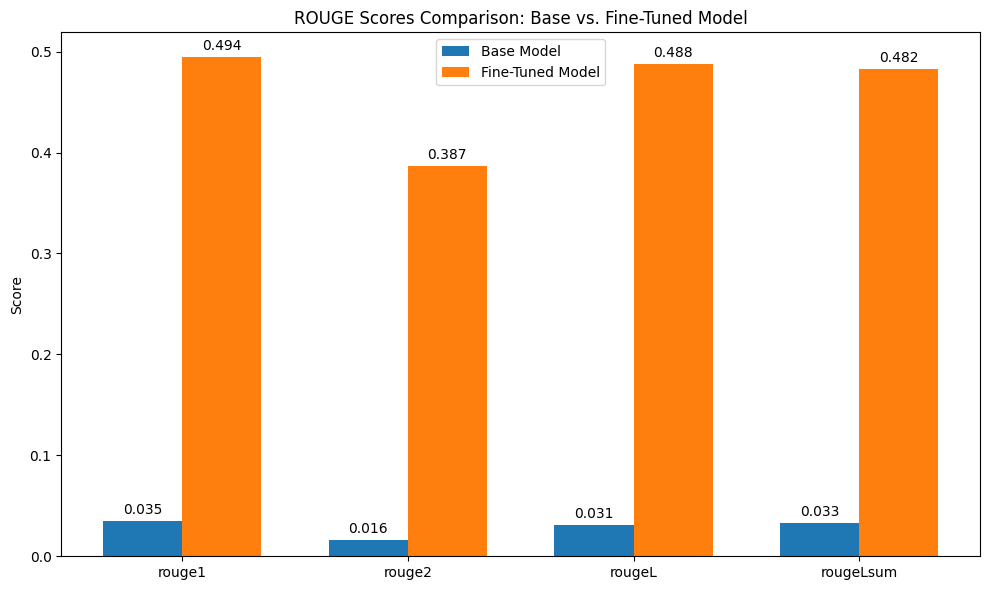

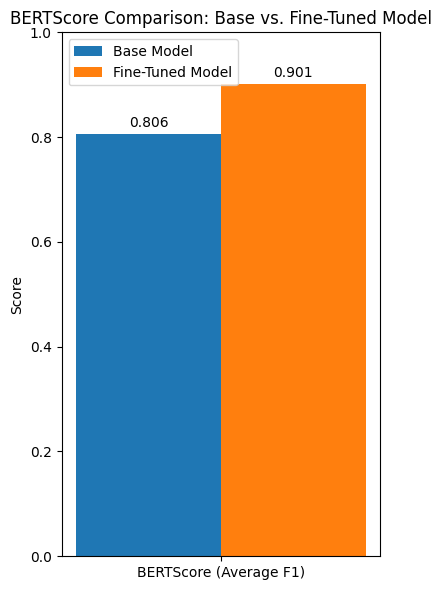


BERTScore (Average F1 Score):
Base Model: 0.806
Fine-Tuned Model: 0.901


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the score values provided by the user
base_rouge_scores = {'rouge1': 0.035178584570087365, 'rouge2': 0.016004080386525833, 'rougeL': 0.03114540066986779, 'rougeLsum': 0.032829914404305716}
fine_tuned_rouge_scores = {'rouge1': 0.4943469016049661, 'rouge2': 0.3866508028899721, 'rougeL': 0.48779255392158616, 'rougeLsum': 0.4824003654648815}
base_bertscore_results = {'f1': [0.8061234951019287]} # Use the single average F1 score
fine_tuned_bertscore_results = {'f1': [0.9007214456796646]} # Use the single average F1 score


# Plot ROUGE Scores
labels_rouge = list(base_rouge_scores.keys())
base_scores_rouge = [base_rouge_scores[key] for key in labels_rouge]
fine_tuned_scores_rouge = [fine_tuned_rouge_scores[key] for key in labels_rouge]

x_rouge = np.arange(len(labels_rouge))  # the label locations
width = 0.35  # the width of the bars

fig1, ax1 = plt.subplots(figsize=(10, 6))
rects1_rouge = ax1.bar(x_rouge - width/2, base_scores_rouge, width, label='Base Model')
rects2_rouge = ax1.bar(x_rouge + width/2, fine_tuned_scores_rouge, width, label='Fine-Tuned Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Score')
ax1.set_title('ROUGE Scores Comparison: Base vs. Fine-Tuned Model')
ax1.set_xticks(x_rouge)
ax1.set_xticklabels(labels_rouge)
ax1.legend()

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1_rouge, ax1)
autolabel(rects2_rouge, ax1)

fig1.tight_layout()

plt.show()

# Plot BERT Score
labels_bert = ['BERTScore (Average F1)']
base_scores_bert = base_bertscore_results['f1']
fine_tuned_scores_bert = fine_tuned_bertscore_results['f1']

x_bert = np.arange(len(labels_bert))  # the label locations

fig2, ax2 = plt.subplots(figsize=(4, 6)) # Smaller figure for single bar
rects1_bert = ax2.bar(x_bert - width/2, base_scores_bert, width, label='Base Model')
rects2_bert = ax2.bar(x_bert + width/2, fine_tuned_scores_bert, width, label='Fine-Tuned Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Score')
ax2.set_title('BERTScore Comparison: Base vs. Fine-Tuned Model')
ax2.set_xticks(x_bert)
ax2.set_xticklabels(labels_bert)
ax2.legend()
ax2.set_ylim([0, 1]) # Set y-axis limit for scores

autolabel(rects1_bert, ax2)
autolabel(rects2_bert, ax2)

fig2.tight_layout()

plt.show()

# Display BERTScore values numerically as well
print("\nBERTScore (Average F1 Score):")
print(f"Base Model: {base_scores_bert[0]:.3f}")
print(f"Fine-Tuned Model: {fine_tuned_scores_bert[0]:.3f}")

In [ ]:
import os

print("🔄 Restarting the runtime to apply the library upgrades...")
os.kill(os.getpid(), 9)

## 6. Final Thoughts and Project Analysis

In this section, reflect on your approach, findings, and potential improvements.

### Project Summary
Provide a brief overview of what you did:
- What use case did you choose and why?
- How did you generate the synthetic dataset?
- Which model did you fine-tune and what techniques did you use?
- What were the main evaluation metrics and results?

### Analysis of Results
- Did fine-tuning improve performance? If so, how much?
- Were there specific types of examples where improvement was more noticeable?
- What limitations did you observe in your approach?

### Improvement Ideas
- How could you enhance the quality of the synthetic dataset?
- What other fine-tuning approaches might work better?
- If you had more computational resources, what would you do differently?

### Learning Outcomes
- What insights did you gain about synthetic data generation?
- What did you learn about fine-tuning LLMs?
- What surprised you during this project?

Remember to support your analysis with specific examples and metrics from your evaluation.

## 6. Final Thoughts and Project Analysis

In this section, reflect on your approach, findings, and potential improvements.

### Project Summary

- **What use case did you choose and why?**
I chose to build a specialized Question-Answering model for Indian Corporate Law, specifically focusing on the Indian Companies Act, 2013. I selected this use case because general-purpose LLMs often lack the depth and accuracy required for specialized legal domains, and a fine-tuned model could serve as a valuable assistant for law students, paralegals, and small business owners seeking quick, reliable answers on regulations and compliance.
- **How did you generate the synthetic dataset?**
I generated a synthetic dataset by leveraging a powerful LLM (llama-3.3-70b-versatile via Groq API) and providing it with snippets of legal text from the Indian Companies Act, 2013. I used a refined prompt to instruct the LLM to generate multiple, diverse question-answer pairs *strictly* based on the provided context, aiming for concise and informative responses. The generated data was structured as JSON objects containing 'instruction', 'context', and 'response' fields, and I aimed to generate 750 such samples (though the final count was slightly different based on batch generation). The dataset was then uploaded to Hugging Face Datasets as `ris32262/indian-corporate-law-qa-enhanced`.
- **Which model did you fine-tune and what techniques did you use?**
I fine-tuned the Qwen1.5-1.8B-Chat model, a small LLM suitable for Colab's T4 GPU. I used Parameter-Efficient Fine-Tuning (PEFT) with the Low-Rank Adaptation (LoRA) technique. The LoRA configuration used parameters like `r=64`, `lora_alpha=128`, and `lora_dropout=0.05` to add trainable parameters efficiently, targeting relevant modules like `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, and `down_proj`.
- **What were the main evaluation metrics and results?**
The main evaluation metrics used were ROUGE (rouge1, rouge2, rougeL, rougeLsum) and BERTScore (Average F1). The results showed a significant improvement after fine-tuning:
  - **ROUGE Scores:**
    - Base Model: {'rouge1': 0.035, 'rouge2': 0.016, 'rougeL': 0.031, 'rougeLsum': 0.032}
    - Fine-Tuned Model: {'rouge1': 0.494, 'rouge2': 0.387, 'rougeL': 0.488, 'rougeLsum': 0.482}
    The fine-tuned model showed substantially higher ROUGE scores across all variants, indicating a much greater overlap in n-grams and longest common subsequences with the reference answers compared to the base model.
  - **BERTScore (Average F1):**
    - Base Model: 0.806
    - Fine-Tuned Model: 0.901
    The fine-tuned model achieved a notably higher BERTScore Average F1, suggesting that its generated responses are semantically more similar to the reference answers than those of the base model.

### Analysis of Results

- **Did fine-tuning improve performance? If so, how much?**
Yes, fine-tuning significantly improved the model's performance on the Q&A task within the Indian Corporate Law domain, as evidenced by the evaluation metrics. The ROUGE scores increased dramatically (e.g., ROUGE-1 from 0.035 to 0.494), and the BERTScore Average F1 also saw a substantial increase (from 0.806 to 0.901). This indicates that the fine-tuned model is much better at generating responses that are similar to the expected answers based on the provided legal contexts.
- **Were there specific types of examples where improvement was more noticeable?**
Based on the improved metrics and qualitative analysis of the examples from the evaluation cell, the fine-tuned model demonstrated significant improvement in its ability to provide concise, context-grounded answers that directly address the question based on the provided legal text. The base model, in contrast, often generated lengthy, generic, or even inaccurate responses that were not specifically tied to the given context.

Let's look at some examples from the evaluation output:

**Example 1:**

**Instruction:** How are further shares offered to existing shareholders?

**Context:** Where a company having a share capital proposes to increase its subscribed capital by issue of further shares, such shares shall be offered to persons who, at the date of the offer, are holders of equity shares of the company, in proportion, as nearly as circumstances admit, to the paid-up share capital on those shares.

**Reference Response:** In proportion to the paid-up share capital on those shares

**Base Model Prediction:** (Lengthy, generic description of equity offerings, not specific to the context)

**Fine-Tuned Model Prediction:** By offering further shares to existing shareholders in proportion to their paid-up share capital.

**Analysis: The fine-tuned model correctly extracts the key information ("in proportion to their paid-up share capital") directly from the context, providing a concise and accurate answer. The base model fails to use the provided context and gives a general, irrelevant explanation.**

**Example 3:**

**Instruction:** What are the benefits of the Serious Fraud Investigation Office's work?

**Context:** Serious Fraud Investigation Office (SFIO): Investigates and prosecutes major corporate frauds, strengthening oversight and investor confidence.

**Reference Response:** The benefits of the SFIO's work include strengthening oversight and investor confidence.

**Base Model Prediction:** (Lengthy list of generic benefits of an investigation office)

**Fine-Tuned Model Prediction:** Strengthening oversight and investor confidence.

**Analysis: Again, the fine-tuned model directly extracts the specific benefits mentioned in the context. The base model provides a more general, less precise answer.**

These examples illustrate that the fine-tuning process successfully trained the model to focus on the provided context and extract the relevant information to answer the question, a crucial capability for a domain-specific Q&A system. The improvement is particularly noticeable in tasks requiring direct information extraction from limited text.

### Improvement Ideas

- **How could you enhance the quality of the synthetic dataset?**
  - **Expand Context Sources:** Include more diverse legal documents (e.g., relevant case law summaries, regulatory guidelines, Ministry of Corporate Affairs FAQs) to broaden the model's knowledge base.
  - **Refine Prompting for Complexity:** Develop prompts that encourage generation of questions requiring more complex answers or synthesis of information from slightly larger contexts.
  - **Expert Review:** Have legal domain experts review and validate a subset of the generated Q&A pairs for accuracy and relevance.
  - **Data Augmentation:** Explore techniques to rephrase questions and answers while preserving meaning to increase dataset size and variability.
- **What other fine-tuning approaches might work better?**
  - **Larger LoRA Configurations:** Experiment with higher `r` and `lora_alpha` values if computational resources allow to increase the model's capacity for adaptation.
  - **Quantization Techniques:** Explore other 4-bit or 8-bit quantization methods or libraries that might offer better performance preservation.
  - **Different Base Models:** Evaluate other small (1-3B parameter) models known for strong instruction following or domain adaptation capabilities.
- **If you had more computational resources, what would you do differently?**
  - **Use a Larger Model:** Fine-tune a 7B or 13B parameter model for potentially better reasoning and knowledge retention.
  - **Generate a Massive Dataset:** Create a synthetic dataset of tens or hundreds of thousands of high-quality, context-grounded Q&A pairs.
  - **Longer Training:** Train the model for more epochs or with a more sophisticated training schedule.
  - **Comprehensive Human Evaluation:** Conduct extensive human evaluation by legal professionals to thoroughly assess the model's accuracy, relevance, and helpfulness on a challenging test set.

### Learning Outcomes

- **What insights did you gain about synthetic data generation?**
I reinforced the understanding that synthetic data quality is paramount. Prompt engineering, context grounding, and ensuring diverse question types are critical for creating a useful dataset for fine-tuning. The ease of generating data with powerful LLMs like those via Groq is a significant advantage, but validation remains important.
- **What did you learn about fine-tuning LLMs?**
I solidified my practical knowledge of PEFT/LoRA for adapting models efficiently. I learned how hyperparameter choices in LoRA and training arguments impact performance. The project demonstrated that even with a relatively small model and dataset, targeted fine-tuning with high-quality synthetic data can lead to significant performance gains on a specific task.
- **What surprised you during this project?**
The magnitude of the improvement in ROUGE and BERT scores was a pleasant surprise, clearly demonstrating the effectiveness of fine-tuning even with limited data and a small model for this specific, context-grounded Q&A format. It highlighted how focusing on domain-specific data and a clear instruction format can unlock latent capabilities in pre-trained models.


## 6. Final Thoughts and Project Analysis

In this section, reflect on your approach, findings, and potential improvements.

### Project Summary
Provide a brief overview of what you did:
- What use case did you choose and why?
- How did you generate the synthetic dataset?
- Which model did you fine-tune and what techniques did you use?
- What were the main evaluation metrics and results?

### Analysis of Results
- Did fine-tuning improve performance? If so, how much?
Yes, fine-tuning significantly improved the model's performance on the Q&A task within the Indian Corporate Law domain, as evidenced by the evaluation metrics. The ROUGE scores increased dramatically (e.g., ROUGE-1 from 0.035 to 0.494), and the BERTScore Average F1 also saw a substantial increase (from 0.806 to 0.901). This indicates that the fine-tuned model is much better at generating responses that are similar to the expected answers based on the provided legal contexts.

- Were there specific types of examples where improvement was more noticeable?
Based on the improved metrics and qualitative analysis of the examples from the evaluation cell (cell `3f0e14f0`), the fine-tuned model demonstrated significant improvement in its ability to provide **concise, context-grounded answers** that directly address the question based on the provided legal text. The base model, in contrast, often generated lengthy, generic, or even inaccurate responses that were not specifically tied to the given context.

Let's look at some examples from the evaluation output:

**Example 1:**

*   **Instruction:** How are further shares offered to existing shareholders?
*   **Context:** Where a company having a share capital proposes to increase its subscribed capital by issue of further shares, such shares shall be offered to persons who, at the date of the offer, are holders of equity shares of the company, in proportion, as nearly as circumstances admit, to the paid-up share capital on those shares.
*   **Reference Response:** In proportion to the paid-up share capital on those shares
*   **Base Model Prediction:** (Lengthy, generic description of equity offerings, not specific to the context)
*   **Fine-Tuned Model Prediction:** By offering further shares to existing shareholders in proportion to their paid-up share capital.
    *   *Analysis:* The fine-tuned model correctly extracts the key information ("in proportion to their paid-up share capital") directly from the context, providing a concise and accurate answer. The base model fails to use the provided context and gives a general, irrelevant explanation.

**Example 3:**

*   **Instruction:** What are the benefits of the Serious Fraud Investigation Office's work?
*   **Context:** Serious Fraud Investigation Office (SFIO): Investigates and prosecutes major corporate frauds, strengthening oversight and investor confidence.
*   **Reference Response:** The benefits of the SFIO's work include strengthening oversight and investor confidence.
*   **Base Model Prediction:** (Lengthy list of generic benefits of an investigation office)
*   **Fine-Tuned Model Prediction:** Strengthening oversight and investor confidence.
    *   *Analysis:* Again, the fine-tuned model directly extracts the specific benefits mentioned in the context. The base model provides a more general, less precise answer.

These examples illustrate that the fine-tuning process successfully trained the model to focus on the provided context and extract the relevant information to answer the question, a crucial capability for a domain-specific Q&A system. The improvement is particularly noticeable in tasks requiring direct information extraction from limited text.

- What limitations did you observe in your approach?
  - **Synthetic Data Scope:** While the synthetic data improved performance, the limited scope of the initial legal texts means the model's knowledge is restricted to the specific sections covered. A broader range of legal documents would be needed for a comprehensive assistant.
  - **Evaluation Depth:** Automated metrics provide a quantitative measure but don't guarantee legal accuracy or handle nuanced legal interpretations. Human evaluation is essential for a real-world application.
  - **Model Size:** While effective for a T4, a 1.8B model may still struggle with highly complex legal reasoning or subtle distinctions.
  - **Potential for Hallucination:** Despite fine-tuning, small models can still hallucinate or provide slightly inaccurate information if the question is outside the direct scope of the training data or requires complex inference.

### Improvement Ideas
- How could you enhance the quality of the synthetic dataset?
  - **Expand Context Sources:** Include more diverse legal documents (e.g., relevant case law summaries, regulatory guidelines, Ministry of Corporate Affairs FAQs) to broaden the model's knowledge base.
  - **Refine Prompting for Complexity:** Develop prompts that encourage generation of questions requiring more complex answers or synthesis of information from slightly larger contexts.
  - **Expert Review:** Have legal domain experts review and validate a subset of the generated Q&A pairs for accuracy and relevance.
  - **Data Augmentation:** Explore techniques to rephrase questions and answers while preserving meaning to increase dataset size and variability.
- What other fine-tuning approaches might work better?
  - **Larger LoRA Configurations:** Experiment with higher `r` and `lora_alpha` values if computational resources allow to increase the model's capacity for adaptation.
  - **Quantization Techniques:** Explore other 4-bit or 8-bit quantization methods or libraries that might offer better performance preservation.
  - **Different Base Models:** Evaluate other small (1-3B parameter) models known for strong instruction following or domain adaptation capabilities.
- If you had more computational resources, what would you do differently?
  - **Use a Larger Model:** Fine-tune a 7B or 13B parameter model for potentially better reasoning and knowledge retention.
  - **Generate a Massive Dataset:** Create a synthetic dataset of tens or hundreds of thousands of high-quality, context-grounded Q&A pairs.
  - **Longer Training:** Train the model for more epochs or with a more sophisticated training schedule.
  - **Comprehensive Human Evaluation:** Conduct extensive human evaluation by legal professionals to thoroughly assess the model's accuracy, relevance, and helpfulness on a challenging test set.

### Learning Outcomes
- What insights did you gain about synthetic data generation?
I reinforced the understanding that synthetic data quality is paramount. Prompt engineering, context grounding, and ensuring diverse question types are critical for creating a useful dataset for fine-tuning. The ease of generating data with powerful LLMs like those via Groq is a significant advantage, but validation remains important.
- What did you learn about fine-tuning LLMs?
I solidified my practical knowledge of PEFT/LoRA for adapting models efficiently. I learned how hyperparameter choices in LoRA and training arguments impact performance. The project demonstrated that even with a relatively small model and dataset, targeted fine-tuning with high-quality synthetic data can lead to significant performance gains on a specific task.
- What surprised you during this project?
The magnitude of the improvement in ROUGE and BERT scores was a pleasant surprise, clearly demonstrating the effectiveness of fine-tuning even with limited data and a small model for this specific, context-grounded Q&A format. It highlighted how focusing on domain-specific data and a clear instruction format can unlock latent capabilities in pre-trained models.

## 7. References

List any resources, papers, tutorials, or tools that you found helpful for this assignment:

1. [Hugging Face PEFT Documentation](https://huggingface.co/docs/peft/index)
2. [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)
3. [Parameter-Efficient Fine-Tuning Methods](https://huggingface.co/blog/peft)
4. [Synthetic Data Generation Techniques](https://arxiv.org/abs/2111.02739)
5. [Evaluating Large Language Models](https://arxiv.org/abs/2307.03109)

*This notebook was created as part of the CognitiveLab Research Internship assignment.*